# XAI507 Computer Vision Assignment 1 - Part 2 (Renderer)

In [10]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from math import atan, sin, cos
import numpy as np


In [11]:
#helper functions as provided in assignment specs

def show_3d(vertices, edges):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]])
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])
plt.show()

<strong> i. define vertices and edges of cube </strong>

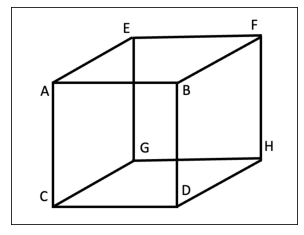

In [20]:
img = mpl.image.imread('cube.png')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#define vertices
vertices = [(-1,1,1),(1,1,1),(-1,-1,1),(1,-1,1),(-1,1,-1),(1,1,-1),(-1,-1,-1),(1,-1,-1)]

#define connected edges
edges = [(0,1),(0,2),(0,4),(1,3),(1,5),(2,3),(2,6),(3,7),(4,5),(4,6),(5,7),(6,7)]

#plot
show_3d(vertices,edges)

<strong> ii. define rotation and translation matrix to find extrinsic matrix. </strong> </br>
Turn points to homogenous and non-homogenous as required. </br>
Camera position = [0,0,-2.5] </br>
Camera orientation = [0,0.1,0]

In [ ]:
#rotation matrix based on formula provided in assignment spec. Add extra row/column to make dimension equal to tranlsation matrix
def rotationMatrix(u,theta):
    ux = u[0]
    uy = u[1]
    uz = u[2]
    ct = cos(theta)
    st = sin(theta)
    row1= [ct+ux**2*(1-ct), ux*uy*(1-ct)-uz*st, ux*uz*(1-ct)+uy*st,0]
    row2 = [uy*ux*(1-ct)+uz*st, ct+uy**2*(1-ct), uy*ux*(1-ct)-ux*st,0]
    row3 = [uz*ux*(1-ct)-uy*st, uz*uy*(1-ct)+ux*st, ct+uz**2*(1-ct),0]
    row4 = [0,0,0,1]
    return [row1,row2,row3,row4]

#translation matrix as per lecture slides
def translateMatrix(x_trans,y_trans,z_trans):
    row1 = [1,0,0,-x_trans]
    row2 = [0,1,0,-y_trans]
    row3 = [0,0,1,-z_trans]
    row4 = [0,0,0,1]
    return [row1, row2, row3, row4]

#function to normalise a vector
def normaliseVector(A):
    return A/np.linalg.norm(A)

#function to find angle between two vectors in radians
def findAngle(A,B):
    mag_A = np.sqrt(A[0]**2+A[1]**2+A[2]**2)
    mag_B = np.sqrt(B[0]**2+B[1]**2+B[2]**2)
    normalise_A = normaliseVector(A)
    normalise_B = normaliseVector(B)
    angle = np.arccos(np.dot(normalise_A,normalise_B))
    return angle

#gets the angle required to rotate given camera orientation vector for direction x, y or z.
def getVectorsRotation(orientation, direction):
    if (direction=="x"):
        x_value = orientation[0]
        if x_value==0:
            return 0
        else:
            return findAngle([1,0,0],[x_value,0,0])
    elif (direction=="y"):
        y_value = orientation[1]
        if y_value==0:
            return 0
        else:
            return findAngle([0,1,0],[0,y_value,0])
    else:
        z_value = orientation[2]
        if z_value==0:
            return 0
        else:
            return findAngle([0,0,1][0,0,z_value])

#returns the final 4x4 extrinisc matrix based on homogenous coordinates
def get_extrinsic_matrix(position, orientation):
    #calculate angle between position and orientation
    angle_x = getVectorsRotation(orientation, "x")
    angle_y = getVectorsRotation(orientation, "y")
    angle_z = getVectorsRotation(orientation, "z")
    #rotate around x-axis and y-axis.
    matrix_mult1 = np.matmul(rotationMatrix([1,0,0],angle_x), rotationMatrix([0,1,0],angle_y)) 
    #then rotate around z-axis
    matrix_mult2 = np.matmul(matrix_mult1, rotationMatrix([0,0,1],angle_z))
    #then translate
    translation_matrix = translateMatrix(position[0],position[1],position[2])
    matrix_mult3 = np.matmul(matrix_mult2,translation_matrix)
    return matrix_mult3

#turns an array of points into homogenous coordinates
def to_homogenous(points): 
    hom_points = []
    for point in points:
        point = point + [1]
        hom_points.append(point)
    return np.array(hom_points)

#converts an array of homogenous coordinates into proper 3D or 2D coordinates
def from_homogenous(points):
    non_hom_points = []
    for point in points:
        divisor = point[-1]
        new_point = []
        for coord in point:
            new_point.append(coord/divisor)
        non_hom_points.append(new_point[:-1])
    return np.array(non_hom_points)
            
     

In [ ]:
position = [0,0,-2.5]
orientation = [0,0.1,0]

#transform cube coordinates into homogenous points
vertices_list = []
for point in vertices:
    vertices_list.append(list(point))
hom_vertices = np.array(to_homogenous(vertices_list))

#get extrinsic matrix
extrinsic_matrix = get_extrinsic_matrix(position, orientation)

#transform vertices by multiplying with extrinsic matrix
vertices_transformed = []
non_hom_vertices_transformed = []
for point in hom_vertices:
    mat = np.matmul(extrinsic_matrix, point.transpose())
    vertices_transformed.append(mat)

#turn back to non-homogenous matrix for the purpose of plotting
non_hom_vertices_transformed = from_homogenous(vertices_transformed)
show_3d(non_hom_vertices_transformed, edges)

<strong> iii. get intrinsic matrix, transform camera coordinates into projected coordinates and plot 2D image. </strong> </br>
Turn points into homogenous and non-homogenous as required.

In [ ]:
#function that creates the full intrinsic transofrmation including the projection matrix
def get_intrinsic_matrix(f,s):
    K = np.array([[f,0,s[0]],[0,f,s[1]],[0,0,1]])
    mat = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
    return np.matmul(K,mat)

In [ ]:
#set focal length and pixel sizes
f = 0.4
s = (0.51, 0.49)

#get intrinsic matrix
intrinsic_matrix = get_intrinsic_matrix(f,s)


#transform camera coordinates into projected coordinates
image = []
for point in vertices_transformed:
    image.append(np.matmul(intrinsic_matrix, point))

#convert to non-homogenous matrix
image = from_homogenous(image)    

#resize image to use helper-function show_2D.
image_resized = np.array(image)*200

#plot image
show_2d(image_resized, edges, [200,200])